# TextRank

Automatic text summarization is the task of producing a concise and fluent summary while preserving key information
content and overall meaning.

1. Extractive Summarization
 - Identifying the important sentences or phrases from the original text and extract only those from the text.

2. Abstractive Summarization
 - Generating new sentences from the original text


3. TextRank: extractive & unsupervised text summarizatoin
 -  Concatenate text -> sentences -> sentence embeddings -> similarity matrix (between vectors) -> graph

### Connect to existence Github repo

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/Shared drives/ZWTZWT

/content/drive/Shared drives/ZWTZWT


In [3]:
!git clone https://github.com/vantuan5644/LungCancerTreatment.git

Cloning into 'LungCancerTreatment'...
remote: Enumerating objects: 6005, done.
remote: Counting objects: 100% (6005/6005), done.
remote: Compressing objects: 100% (5324/5324), done.
remote: Total 6005 (delta 795), reused 5799 (delta 594), pack-reused 0
Receiving objects: 100% (6005/6005), 22.92 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (795/795), done.


In [7]:
%cd LungCancerTreatment/

/content/drive/Shared drives/ZWTZWT/LungCancerTreatment


## TextRank

In [7]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Choose a stage to use TextRank algorithm and inference se12seq model

In [0]:
stage = 'stage 1'

### Splitting into sentences

In [19]:
data = pd.read_csv(f'data_crawled/{stage}.csv')
data.head()


,url,title,snippet,text
0,https://www.cancer.gov/types/lung/patient/non-...,How We Treat Non-Small Cell Lung Cancer - Dana...,... tomography for mediastinal staging in pati...,NaN
1,https://www.cancer.gov/types/lung/hp/non-small...,How We Treat Non-Small Cell Lung Cancer - Dana...,... tomography for mediastinal staging in pati...,NaN
2,https://www.cancer.org/cancer/lung-cancer/trea...,Management of stage I and stage II non-small c...,... tomography for mediastinal staging in pati...,"If you have stage I NSCLC, surgery may be the ..."
3,https://www.uptodate.com/contents/management-o...,Treatment of stage I and II non-small cell lun...,... tomography for mediastinal staging in pati...,NaN
4,https://www.uptodate.com/contents/non-small-ce...,Treatment of stage I and II non-small cell lun...,... tomography for mediastinal staging in pati...,NaN


In [0]:
# stage_level = data[['text', 'stage_level']].groupby('stage_level').agg({'text': lambda text: ' '.join(text),
#                                                                         })
# data = stage_level.reset_index(level=0)
# data

In [21]:
# Split text into sentences
from nltk. tokenize import sent_tokenize
sentences = []
for s in data[data['text'].notnull()]['text']:
    sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x] # flatten list
sentences[:5]

['If you have stage I NSCLC, surgery may be the only treatment you need.',
 'This may be done either by taking out the lobe of the lung that has the tumor (lobectomy) or by taking out a smaller piece of the lung (sleeve resection, segmentectomy, or wedge resection).',
 'At least some lymph nodes in the lung and in the space between the lungs will also be removed and checked for cancer.,Segmentectomy or wedge resection is generally an option only for very small stage I cancers and for patients with other health problems that make removing the entire lobe dangerous.',
 'Still, most surgeons believe it is better to do a lobectomy if the patient can tolerate it, as it offers the best chance for cure.,For people with stage I NSCLC that has a higher risk of coming back (based on size, location, or other factors), adjuvant chemotherapy after surgery may lower the risk that cancer will return.',
 'But doctors aren’t always sure how to determine which people are likely to be helped by chemo.']

### Make sentences embeddings from GloVe

In [22]:
# GloVe Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-04-27 07:57:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-27 07:57:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-27 07:57:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()


#### Text Preprocessing

Remove new-line character

In [0]:
clean_sentences = [re.sub('\n+', ' ', sent) for sent in sentences]


Remove stopwords

In [32]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]


#### Make sentence vectors from word embeddings

In [0]:
sentence_vectors = []
for i in clean_sentences:
  if len(i) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split()))
  else:
    v = np.zeros((100,))
  sentence_vectors.append(v)
  
assert len(sentences) == len(sentence_vectors)

In [35]:
sentence_vectors[0].shape

(100,)

### Similarity Matrix Preparation

In [0]:
# Similarity matrix is a zero matrix with dimension (n, n)
# We will initialize this matrix with cosine similarity of the sentences 
sim_mat = np.zeros([len(sentences), len(sentences)])


In [0]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(sentences)):
  for j in range(len(sentences)):
    if i != j:
      sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]


### Applying PageRank algorithm

#### Convert into graph

We need to convert the similarity matrix **sim_mat** into a graph.

The nodes of this graph will represent the sentences and the edges will represent the similarity scores between sentences.

In [0]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)


#### Summary Extraction

Extracting the top N sentences based on their rankings for summary generation

In [0]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)


In [42]:
# Extract top 10 sentences as the summary
for i in range(3):
  print(ranked_sentences[i][1])


Still, most surgeons believe it is better to do a lobectomy if the patient can tolerate it, as it offers the best chance for cure.,For people with stage I NSCLC that has a higher risk of coming back (based on size, location, or other factors), adjuvant chemotherapy after surgery may lower the risk that cancer will return.
Still, most surgeons believe it is better to do a lobectomy if the patient can tolerate it, as it offers the best chance for cure.,For people with stage I NSCLC that has a higher risk of coming back (based on size, location, or other factors), adjuvant chemotherapy after surgery may lower the risk that cancer will return.
This could mean that some cancer has been left behind, so a second surgery might be done to try to ensure that all the cancer has been removed.


# Sequence-to-Sequence Modeling

There are two major components of a Seq2Seq model:

- Encoder: An LSTM model reads the entire input sequence wherein, at each timestep, one word is fed into the encoder. It then processes the information at every timestep and captures the contextual information present in the input sequence.

![LSTM Encoder](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/61.jpg)


- Decoder: An LSTM network which reads the entire target sequence word-by-word and predicts the same sequence offset by one timestep. **The decoder is trained to predict the next word in the sequence given the previous word.**

![LSTM Decoder](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/71.jpg)


The encoder converts the entire input sequence into a fixed length vector and then the decoder predicts the output sequence. Hence it is difficult for the encoder to memorize long sequences into a fixed length vector. We can overcome this issue by using **attention mechanism**, that aims to predict a word by looking at a few specific parts of the sequence only, rather than the entire sequence.


### Train on AmazonFineFoodReview Dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.



In [2]:
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
import tensorflow as tf
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [8]:
%cd /content/drive/Shared drives/ZWTZWT/LungCancerTreatment/src/text_summarization/

/content/drive/Shared drives/ZWTZWT/LungCancerTreatment/src/text_summarization


In [45]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vantuan5644","key":"e42b59d4233ccff575f11002cc6e0c90"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [47]:
import os
os.getcwd()


'/content/drive/Shared drives/ZWTZWT/LungCancerTreatment/src/text_summarization'

In [0]:
!kaggle datasets list -s amazon


ref                                                  title                                               size  lastUpdated          downloadCount  
---------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
snap/amazon-fine-food-reviews                        Amazon Fine Food Reviews                           242MB  2017-05-01 18:51:31          67526  
sid321axn/amazon-alexa-reviews                       Amazon Alexa Reviews                               164KB  2018-07-31 17:45:14           7724  
bittlingmayer/amazonreviews                          Amazon Reviews for Sentiment Analysis              493MB  2019-11-18 02:50:34          23275  
grikomsn/amazon-cell-phones-reviews                  Amazon Cell Phones Reviews                           9MB  2019-12-26 22:21:16           6143  
datafiniti/consumer-reviews-of-amazon-products       Consumer Reviews of Amazon Products                 16MB  2

In [48]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

100% 241M/242M [00:08<00:00, 25.8MB/s]
100% 242M/242M [00:08<00:00, 29.1MB/s]


In [49]:
os.listdir(os.getcwd())

['__init__.py',
 'contraction.py',
 'extractive_textrank.ipynb',
 'sentences_transformer.py',
 'kaggle.json',
 'amazon-fine-food-reviews.zip']

In [0]:
dataset_file = os.getcwd() + '/amazon-fine-food-reviews.zip'
import zipfile
zip_ref = zipfile.ZipFile(dataset_file, 'r') 
zip_ref.extractall()
zip_ref.close()


In [51]:
os.listdir(os.getcwd())

['__init__.py',
 'contraction.py',
 'extractive_textrank.ipynb',
 'sentences_transformer.py',
 'kaggle.json',
 'amazon-fine-food-reviews.zip',
 'Reviews.csv',
 'database.sqlite',
 'hashes.txt']

### Load the dataset

In [0]:
data = pd.read_csv("Reviews.csv")


In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


Drop duplicates and NA values

In [0]:
data.drop_duplicates(subset=['Text'], inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [0]:
from contraction import contraction_mapping

#### Text cleaning
 - Convert to lowercase
 - Remove HTML tags
 - Contraction mapping
 - Remove special characters
 - Remove stopwords


In [55]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Text cleaning: 
 - Remove quote "
 - Contraction mapping: i.e "i'd've": "i would have", "i'll": "i will"
 - Remove HTML tags
 - Remove 's
 - Remove stopwords
 - Remove punctuations and special characters
 - Remove shortwords

In [0]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=2:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

Summarization cleaning: 
 - Remove quote "
 - Contraction mapping: i.e "i'd've": "i would have", "i'll": "i will"
 - Remove 's
 - Remove punctuations and special characters
 - Remove shortwords

In [0]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [79]:
print(len(cleaned_text), len(cleaned_summary))

392421 392421


In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)


#### Load cleaned data

In [0]:
if not os.path.isfile('amazon_fine_food_review_cleaned.csv'):
  data[['cleaned_text', 'cleaned_summary']].to_csv('amazon_fine_food_review_cleaned.csv', index=False)

In [10]:
data = pd.read_csv('amazon_fine_food_review_cleaned.csv')
data

,cleaned_text,cleaned_summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
...,...,...
392416,great sesame chicken good better resturants eaten husband loved find recipes use,will not do without
392417,disappointed flavor chocolate notes especially weak milk thickens flavor still disappoints worth try never buy use left gone time thanks small cans,disappointed
392418,stars small give one training session tried train dog ceaser dog treats made puppy hyper compare ingredients know little stars basic food ingredients without preservatives food coloring sweet pota...,perfect for our maltipoo
392419,best treats training rewarding dog good grooming lower calories loved doggies sweet potatoes seem favorite wet noses treat,favorite training and reward treat


Add the **START** and **END** token to the label (summary)

In [0]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')


texts variable contains all text strings, used for creating embeddings matrix

In [0]:
texts = data['cleaned_text']
texts = texts.append(data['cleaned_summary']).to_list()

In [13]:
len(texts)

784842

Text length distribution


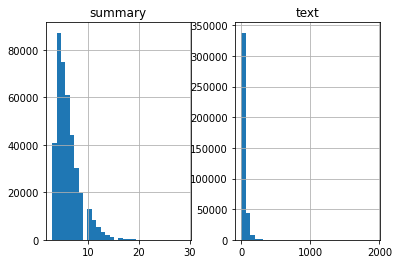

In [14]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

max_len_text = 0
max_len_summary = 0

# populate the lists with sentence lengths
for i in data['cleaned_text']:
  nof_words = len(str(i).split())
  max_len_text = max(max_len_text, nof_words)
  text_word_count.append(nof_words)

for i in data['cleaned_summary']:
  nof_words = len(str(i).split())
  max_len_summary = max(max_len_summary, nof_words)

  summary_word_count.append(nof_words)

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()


In [15]:
print(max_len_text, max_len_summary)

1919 29


In [0]:
max_len_text=80 
max_len_summary=10


## Learn word embeddings

### Train test split

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(data['cleaned_text'].astype(str), data['cleaned_summary'].astype(str),
                                         test_size=0.1, 
                                         random_state=0,
                                         shuffle=True) 


In [63]:
x_tr

373953                                                                               scent cinnamon cloves authentic strong far many cloves overall flavor profile seemed skewed black tea portion could stronger
367239    used waffles mix good testing kitchenaid pro line waffle maker waffles came light crispy soft moist interior cooking house smelled amazing also tested betty crocker scratch recipe waffles came bit...
57674     small espresso enough satisfy coffee craving iced frappicino type drink cream milk barely enough sweetness coffee rich strong bitter adding teaspoon sugar fixed guess could heat hot espresso iced ...
298415                          product work see moths flying right bought years ago work well better ones putting year good woolen clothes ruined please say something stupid like clean things putting away duh
348092    wonder people reported work consume lot caffine use caffine products coca tea certainly positive effect without caffine jitters feel improved energy c

In [64]:
y_tr

373953                          _START_ too many cloves  _END_
367239                                _START_ very good  _END_
57674                     _START_ very strong yumminess  _END_
298415     _START_ don waste your money or your woolens  _END_
348092                             _START_ liked it lot  _END_
                                  ...                         
359783                                   _START_ pepper  _END_
358083                                _START_ good nuts  _END_
152315    _START_ even better than the busha browne rub  _END_
117952                         _START_ slim jims review  _END_
305711            _START_ best donut shop coffee in cup  _END_
Name: cleaned_summary, Length: 353178, dtype: object

### Tokenizing

Text Tokenizer

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences

x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1


In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1


Vocab size


In [67]:
print(x_voc_size, y_voc_size)

115125 31032


### Model building

Attention Layer

In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

3 LSTM layers

In [69]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(x_voc_size, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 100)      11512500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


### Model fitting

Early stopping

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)


In [73]:
print(x_tr.shape, y_tr.shape, x_val.shape, y_val.shape)

(353178, 80) (353178, 10) (39243, 80) (39243, 10)


In [79]:
x_tr[0]

array([ 1011,   359,  3241,  1453,   130,   129,    65,  3241,   379,
           8,  2863,   600, 18738,   235,    10,  1073,    36,   845,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [81]:
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],
                  batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 353178 samples, validate on 39243 samples
Epoch 1/50
   128/353178 [..............................] - ETA: 32:32WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


TypeError: ignored

## Use Pretrained Word Embeddings

#### Use pretrained GloVe embedding layer


In [0]:
class GlobalConfigs:
  num_words = 150000
  embeddings_dim = 300
  project_root_dir = '/content/drive/Shared drives/ZWTZWT/LungCancerTreatment/'
  max_len_text = 80
  max_len_summary = 10
  start_token = '_START_ '
  end_token =  ' _END_'
  unknown_emb = np.random.rand(1, embeddings_dim)
  model_path = os.path.join(project_root_dir, 'src', 'text_summarization', 'models', 'weights.h5')

In [0]:
# Preparing GloVe
embeddings_index = {}
f = open(os.path.join(GlobalConfigs.project_root_dir, 'glove.6B.{}d.txt'.format(GlobalConfigs.embeddings_dim)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


Make embeddings matrix

In [0]:
tokenizer = Tokenizer(num_words=GlobalConfigs.num_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)


In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 136944 unique tokens.


In [0]:
def get_embeddings_matrix(embeddings_dimension, embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, embeddings_dimension))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix


In [0]:
def get_embedding_layer(max_input_length, layer_name):
  layer = Embedding(len(tokenizer.word_index) + 1, GlobalConfigs.embeddings_dim,
                    weights=[get_embeddings_matrix(GlobalConfigs.embeddings_dim, embeddings_index)],
                    input_length=max_input_length, trainable=False,  name=layer_name)
  return layer

#### Index2Word & Word2Index

In [0]:
from collections import Counter


In [0]:
def fit_text(X, Y, input_seq_max_length=None, target_seq_max_length=None):
    if input_seq_max_length is None:
        input_seq_max_length = GlobalConfigs.max_len_text
    if target_seq_max_length is None:
        target_seq_max_length = GlobalConfigs.max_len_summary
    input_counter = Counter()
    target_counter = Counter()
    max_input_seq_length = 0
    max_target_seq_length = 0

    for line in X:
        text = [word.lower() for word in line.split(' ')]
        seq_length = len(text)
        if seq_length > input_seq_max_length:
            text = text[0:input_seq_max_length]
            seq_length = len(text)
        for word in text:
            input_counter[word] += 1
        max_input_seq_length = max(max_input_seq_length, seq_length)

    for line in Y:
        line2 = 'START ' + line.lower() + ' END'
        text = [word for word in line2.split(' ')]
        seq_length = len(text)
        if seq_length > target_seq_max_length:
            text = text[0:target_seq_max_length]
            seq_length = len(text)
        for word in text:
            target_counter[word] += 1
            max_target_seq_length = max(max_target_seq_length, seq_length)

    input_word2idx = dict()
    for idx, word in enumerate(input_counter.most_common(GlobalConfigs.num_words)):
        input_word2idx[word[0]] = idx + 2
    input_word2idx['PAD'] = 0
    input_word2idx['UNK'] = 1
    input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])

    target_word2idx = dict()
    for idx, word in enumerate(target_counter.most_common(GlobalConfigs.num_words)):
        target_word2idx[word[0]] = idx + 1
    target_word2idx['UNK'] = 0

    target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])
    
    num_input_tokens = len(input_word2idx)
    num_target_tokens = len(target_word2idx)

    config = dict()
    config['input_word2idx'] = input_word2idx
    config['input_idx2word'] = input_idx2word
    config['target_word2idx'] = target_word2idx
    config['target_idx2word'] = target_idx2word
    config['num_input_tokens'] = num_input_tokens
    config['num_target_tokens'] = num_target_tokens
    config['max_input_seq_length'] = max_input_seq_length
    config['max_target_seq_length'] = max_target_seq_length

    return config

### Custom Attention Layer

In [0]:
from attention import AttentionLayer

### Attention Model

In [0]:
def seq2seq_attention_model(hidden_dim, embedding_dim, max_len_encoder, max_len_decoder):
  # Encoder
  encoder_inputs = Input(shape=(max_len_encoder,))

  # embedding layer
  enc_emb =  get_embedding_layer(max_len_encoder, layer_name='emb_encoder')(encoder_inputs)

  # encoder lstm 1
  encoder_lstm1 = LSTM(hidden_dim, return_sequences=True, return_state=True)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  # encoder lstm 2
  encoder_lstm2 = LSTM(hidden_dim, return_sequences=True, return_state=True)
  encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

  # Set up the decoder. 
  decoder_inputs = Input(shape=(None,)) 
  dec_emb_layer = get_embedding_layer(max_len_decoder, layer_name='emb_decoder')
  dec_emb = dec_emb_layer(decoder_inputs) 

  # LSTM using encoder_states as initial state
  decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True) 
  decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

  # Attention Layer
  attn_layer = AttentionLayer(name='attention_layer') 
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

  # Concat attention output and decoder LSTM output 
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  # Dense layer
  decoder_dense = TimeDistributed(Dense(max_len_decoder, activation='softmax')) 
  decoder_outputs = decoder_dense(decoder_concat_input) 

  # Define the model
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
  return model



In [0]:
model = seq2seq_attention_model(hidden_dim=300, embedding_dim=GlobalConfigs.embeddings_dim,
                                max_len_encoder=GlobalConfigs.max_len_text,
                                max_len_decoder=GlobalConfigs.max_len_summary)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
emb_encoder (Embedding)         (None, 80, 300)      41083500    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 300), (N 721200      emb_encoder[0][0]                
______________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])


### Data loader

In [0]:
config = fit_text(data['cleaned_text'], data['cleaned_summary'])


In [0]:
class Seq2SeqGloVeSummarizer:
  def __init__(self, config, model):
    self.max_input_seq_length = config['max_input_seq_length']
    self.num_target_tokens = config['num_target_tokens']
    self.max_target_seq_length = config['max_target_seq_length']
    self.target_word2idx = config['target_word2idx']
    self.target_idx2word = config['target_idx2word']
    self.version = 0
    if 'version' in config:
      self.version = config['version']

    self.word2em = dict()
    if 'unknown_emb' in config:
      self.unknown_emb = config['unknown_emb']
    else:
      self.unknown_emb = GlobalConfigs.unknown_emb
      config['unknown_emb'] = self.unknown_emb

    self.config = config
    self.model = model

  def transform_input_text(self, texts):
    temp = []
    for line in texts:
        x = np.zeros(shape=(self.max_input_seq_length, GlobalConfigs.embeddings_dim))
        for idx, word in enumerate(line.lower().split(' ')):
            if idx >= self.max_input_seq_length:
                break
            emb = self.unknown_emb
            if word in self.word2em:
                emb = self.word2em[word]
            x[idx, :] = emb
        temp.append(x)
    temp = pad_sequences(temp, maxlen=self.max_input_seq_length)

    print(temp.shape)
    return temp

  def transform_target_encoding(self, texts):
    temp = []
    for line in texts:
        x = []
        for word in line.split(' '):
            x.append(word)
            if len(x) >= self.max_target_seq_length:
                break
        temp.append(x)

    temp = np.array(temp)
    print(temp.shape)
    return temp

  def generate_batch(self, x_samples, y_samples, batch_size):
    num_batches = len(x_samples) // batch_size
    while True:
      for batchIdx in range(0, num_batches):
        start = batchIdx * batch_size
        end = (batchIdx + 1) * batch_size
        encoder_input_data_batch = pad_sequences(x_samples[start:end], self.max_input_seq_length)
        decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
        decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, GlobalConfigs.embeddings_dim))
        for lineIdx, target_words in enumerate(y_samples[start:end]):
          for idx, w in enumerate(target_words):
            w2idx = 0  # default [UNK]
            if w in self.word2em:
              emb = self.unknown_emb
              decoder_input_data_batch[lineIdx, idx, :] = emb
            if w in self.target_word2idx:
              w2idx = self.target_word2idx[w]
            if w2idx != 0:
              if idx > 0:
                decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
          yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

  def fit(self, Xtrain, Ytrain, Xtest, Ytest, epochs=20, batch_size=32, model_path=GlobalConfigs.model_path):

      Ytrain = self.transform_target_encoding(Ytrain)
      Ytest = self.transform_target_encoding(Ytest)

      Xtrain = self.transform_input_text(Xtrain)
      Xtest = self.transform_input_text(Xtest)

      train_gen = self.generate_batch(Xtrain, Ytrain, batch_size)
      test_gen = self.generate_batch(Xtest, Ytest, batch_size)

      train_num_batches = len(Xtrain) // batch_size
      test_num_batches = len(Xtest) // batch_size

      history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                          epochs=epochs,
                                          verbose=VERBOSE, validation_data=test_gen, validation_steps=test_num_batches,
                                          callbacks=[checkpoint])
      self.model.save_weights(model_path)
      return history

  def summarize(self, input_text):
        input_seq = np.zeros(shape=(1, self.max_input_seq_length, GlobalConfigs.embeddings_dim))
        for idx, word in enumerate(input_text.lower().split(' ')):
            if idx >= self.max_input_seq_length:
                break
            emb = self.unknown_emb  # default [UNK]
            if word in self.word2em:
                emb = self.word2em[word]
            input_seq[0, idx, :] = emb
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, GlobalConfigs.embeddings_dim))
        target_seq[0, 0, :] = self.word2em['start']
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'start' and sample_word != 'end':
                target_text += ' ' + sample_word

            if sample_word == 'end' or target_text_len >= self.max_target_seq_length:
                terminated = True

            if sample_word in self.word2em:
                target_seq[0, 0, :] = self.word2em[sample_word]
            else:
                target_seq[0, 0, :] = self.unknown_emb

            states_value = [h, c]
        return target_text.strip()


### Model training

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['cleaned_summary'],
                                                    test_size=0.1, random_state=0, shuffle=True) 


In [0]:
summarizer = Seq2SeqGloVeSummarizer(config, model)


In [0]:
history = summarizer.fit(X_train, y_train, X_test, y_test, epochs=20, batch_size=4)


(353366,)
(39263,)
